# SECTION 1 — Glossario operativo

Prima di iniziare, definiamo con parole semplici tutti i termini tecnici che useremo. L’obiettivo è leggere ogni sezione senza inciampare nel gergo.

- **Feature**: una variabile di input che descrive l’osservazione (es. prezzo di listino, età, numero di accessi a un sito).
- **Collinearità**: quando una feature è quasi una copia lineare di un’altra, i coefficienti diventano instabili e faticano a distinguere l’effetto delle singole variabili.
- **Modello lineare**: calcola una combinazione pesata delle feature più un termine di bias; geometria: un iperpiano nello spazio delle feature.
- **Decision boundary**: la frontiera geometrica (linea in 2D, piano in 3D, iperpiano in dimensioni maggiori) che separa le classi nel modello di classificazione.
- **Logit**: la trasformazione logaritmica delle probabilità, $\log \frac{p}{1-p}$, che permette di modellare probabilità con una combinazione lineare.
- **Odds**: il rapporto tra probabilità di successo e insuccesso, $\frac{p}{1-p}$.
- **Odds ratio**: come cambiano gli odds quando una feature aumenta di una unità; è l’esponenziale del coefficiente logistico.
- **Sigmoid**: la funzione $\sigma(z) = \frac{1}{1 + e^{-z}}$ che schiaccia il logit $z$ in un intervallo di probabilità tra 0 e 1.
- **Probability model**: un modello che restituisce probabilità (es. logistic regression produce $P(y=1\mid x)$) invece di classi secche.
- **Regularizzazione**: penalità sui coefficienti (L1, L2) che riduce overfitting e stabilizza il modello, soprattutto in presenza di molte feature o collinearità.
- **Linear model per regressione**: stima un valore continuo (es. prezzo di una casa) come combinazione lineare delle feature.
- **Linear model per classificazione**: modella il logit di una probabilità come combinazione lineare e usa la soglia per decidere la classe.
- **Metodo di pensiero**: per ogni sezione, chiediti “qual è l’iperpiano che meglio separa o approssima i dati?” e “quanto è stabile/interpretabile il coefficiente di ciascuna feature?”


# Introduzione ai Modelli Lineari

Notebook dedicato a regressione e classificazione lineare con Scikit-Learn. Seguiamo un filo logico: geometria dell’iperpiano, interpretazione dei coefficienti, stabilità numerica e verifica sperimentale.

## Metodo di pensiero

Immagina ogni modello come un iperpiano che taglia lo spazio delle feature: vogliamo che questo taglio sia semplice da spiegare, stabile quando cambiano leggermente i dati e sufficientemente accurato per l’uso reale. Ogni sezione alterna teoria breve, esempi applicati e passi operativi.

## Perché modelli lineari prima di tutto

- Sono interpretabili: ogni coefficiente racconta come cambia logit o target al crescere di una feature.
- Sono veloci da addestrare e ottime baseline per capire se servono modelli più complessi.
- Hanno geometria chiara: una decision boundary è un iperpiano; i residui mostrano dove la linearità fallisce.

## Esempi applicati (2–3 per contesto)

- **Credito**: previsione di default con poche variabili (reddito, debito, storicità), utile per triage veloce.
- **Assicurazioni**: stima lineare del premio medio o probabilità di sinistro con poche covariate note.
- **Churn e marketing**: logit del rischio di abbandono in funzione di utilizzo, ticket aperti, campagne ricevute.

## Struttura del notebook

1. Pipeline completa di classificazione con standardizzazione e metriche.
2. Lettura e interpretazione dei coefficienti (log-odds e odds ratio).
3. Regressione lineare con valutazione RMSE e $R^2$.
   Ogni sezione mantiene equazioni originali e aggiunge esempi reali per consolidare l’intuizione geometrica e probabilistica.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    mean_squared_error,
    r2_score,
)
from sklearn.datasets import make_classification, make_regression


# SECTION 2 — Teoria sintetica

Un modello lineare approssima la relazione tra feature e target come combinazione pesata:

$$\hat{y} = w_1 x_1 + w_2 x_2 + \dots + w_n x_n + b$$

- I **pesi** $w_i$ misurano quanto cresce o cala la previsione al variare di una feature, a parità delle altre.
- Il **bias** $b$ trasla l’iperpiano nello spazio delle feature.

### 🔹 Regressione Lineare

È addestrata minimizzando l’errore quadratico medio:

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$$

**Esempi applicati**: prezzo medio di un immobile in funzione di metri quadri e posizione; consumo energetico previsto in base a temperatura esterna e orario; costo di una spedizione in base a peso e distanza.

### 🔹 Logistic Regression

La combinazione lineare diventa un **logit**:

$$z = \mathbf{w}^T \mathbf{x} + b$$

che viene trasformato in probabilità tramite funzione sigmoide:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

La previsione è:

$$\hat{p} = P(y=1\mid x) = \sigma(\mathbf{w}^T\mathbf{x} + b)$$

**Esempi applicati**: email spam vs. ham basandosi su frequenze di parole; rischio di default di un cliente in funzione di reddito e debito; esito di una campagna marketing (click/non click) dato il profilo utente.

### 🔹 Perché standardizzare?

- Rende comparabili i coefficienti.
- Evita che una variabile domini la discesa del gradiente.
- Migliora stabilità e convergenza dei solver.

### 🔹 Punti di forza

- Estrema interpretabilità.
- Addestramento rapido.
- Funzionano bene come baseline.

### 🔹 Limiti

- Assumono relazioni quasi lineari.
- Sensibilità ad outlier.
- Non catturano pattern complessi senza feature engineering.

### Metodo di pensiero

Visualizza l’iperpiano come un taglio: chiediti se i dati reali possono essere separati o approssimati da quella superficie. Se i residui mostrano strutture non lineari, considera trasformazioni di feature o modelli più flessibili.


# SECTION 3 — Esercizio 1: Logistic Regression Pipeline

Costruiamo una pipeline completa per classificazione binaria, curando dati, scala, modello e metriche. Questo è il percorso minimo ma rigoroso per validare un modello interpretabile.

## Passaggi richiesti

1. Generare dataset sintetico con `make_classification`.
2. Eseguire EDA (class balance, distribuzioni, duplicati, NaN).
3. Dividere train/test.
4. Applicare `StandardScaler`.
5. Addestrare `LogisticRegression`.
6. Valutare con accuracy, precision, recall.

## Funzioni chiave

- **make_classification**: genera dati artificiali con controllo su informatività e rumore.
- **train_test_split**: separa dati per training e generalizzazione.
- **StandardScaler**: normalizza con:
  $$x' = \frac{x - \mu}{\sigma}$$
- **LogisticRegression**: modella il log-odds lineare.
- Metriche: `accuracy_score`, `precision_score`, `recall_score`.

## Esempi applicati

- **Fraud detection**: transazione sospetta (1) vs. regolare (0) con importo, device, paese.
- **Churn**: abbandono cliente (1) vs. resta (0) usando frequenza d’uso, ticket aperti, canale di acquisizione.
- **Priorità clinica**: ricovero urgente (1) vs. ordinario (0) con segni vitali e anamnesi sintetica.

## Metodo di pensiero

- Verifica prima il bilanciamento delle classi: una decision boundary sensata deve considerare la classe rara.
- Standardizza per dare pari opportunità a ogni feature e rendere leggibili i coefficienti.
- Usa metriche multiple: la sola accuracy può nascondere errori gravi su classi minoritarie.


In [2]:
# Generazione dataset binario
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=6,
    n_redundant=2,
    n_classes=2,
    weights=[0.6, 0.4],
    class_sep=1.0,
    random_state=42,
)
df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
df["target"] = y
print(f"Shape: {X.shape}, Positive ratio: {y.mean():.2f}")
df

Shape: (1000, 10), Positive ratio: 0.40


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,target
0,-1.030931,1.391626,0.547274,0.928932,-1.738880,1.250002,1.332551,1.578256,2.124722,-0.318434,0
1,-2.766254,1.247870,-0.303691,1.083145,0.710836,1.968202,-1.794192,2.346422,1.700778,-0.001190,1
2,-0.558987,0.299849,1.527071,0.360442,-1.360209,1.100793,-0.755951,1.331933,2.041105,-0.824404,0
3,-1.350289,-2.046078,-0.614264,0.126459,-0.783923,5.895026,-0.915477,-3.184768,-0.399260,-3.920960,0
4,-0.275754,-0.728495,0.027727,-0.660834,-1.928161,3.544945,1.446944,-1.111662,0.313766,-2.376528,0
...,...,...,...,...,...,...,...,...,...,...,...
995,-0.326662,0.667346,-1.258075,-1.075737,-1.266081,1.746493,-0.528998,-2.528915,-0.244415,-1.203668,0
996,0.075206,0.198699,1.878295,-1.007868,-1.424495,-1.149712,-0.608494,1.537761,2.524093,0.864625,0
997,-2.728454,-0.352948,1.461926,1.127686,-3.808356,6.246633,0.958816,0.233868,4.350736,-3.104087,0
998,0.107227,1.676627,-0.235451,-1.210161,-0.408889,1.080665,-0.157025,2.201371,-0.727689,-1.082463,0


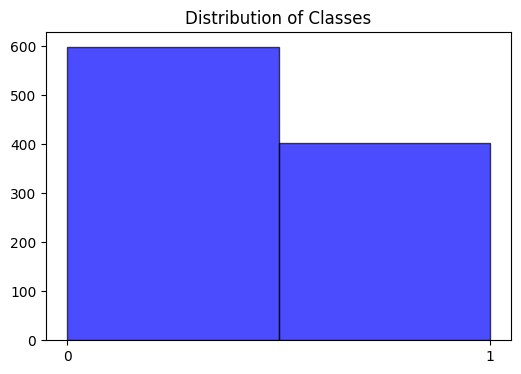

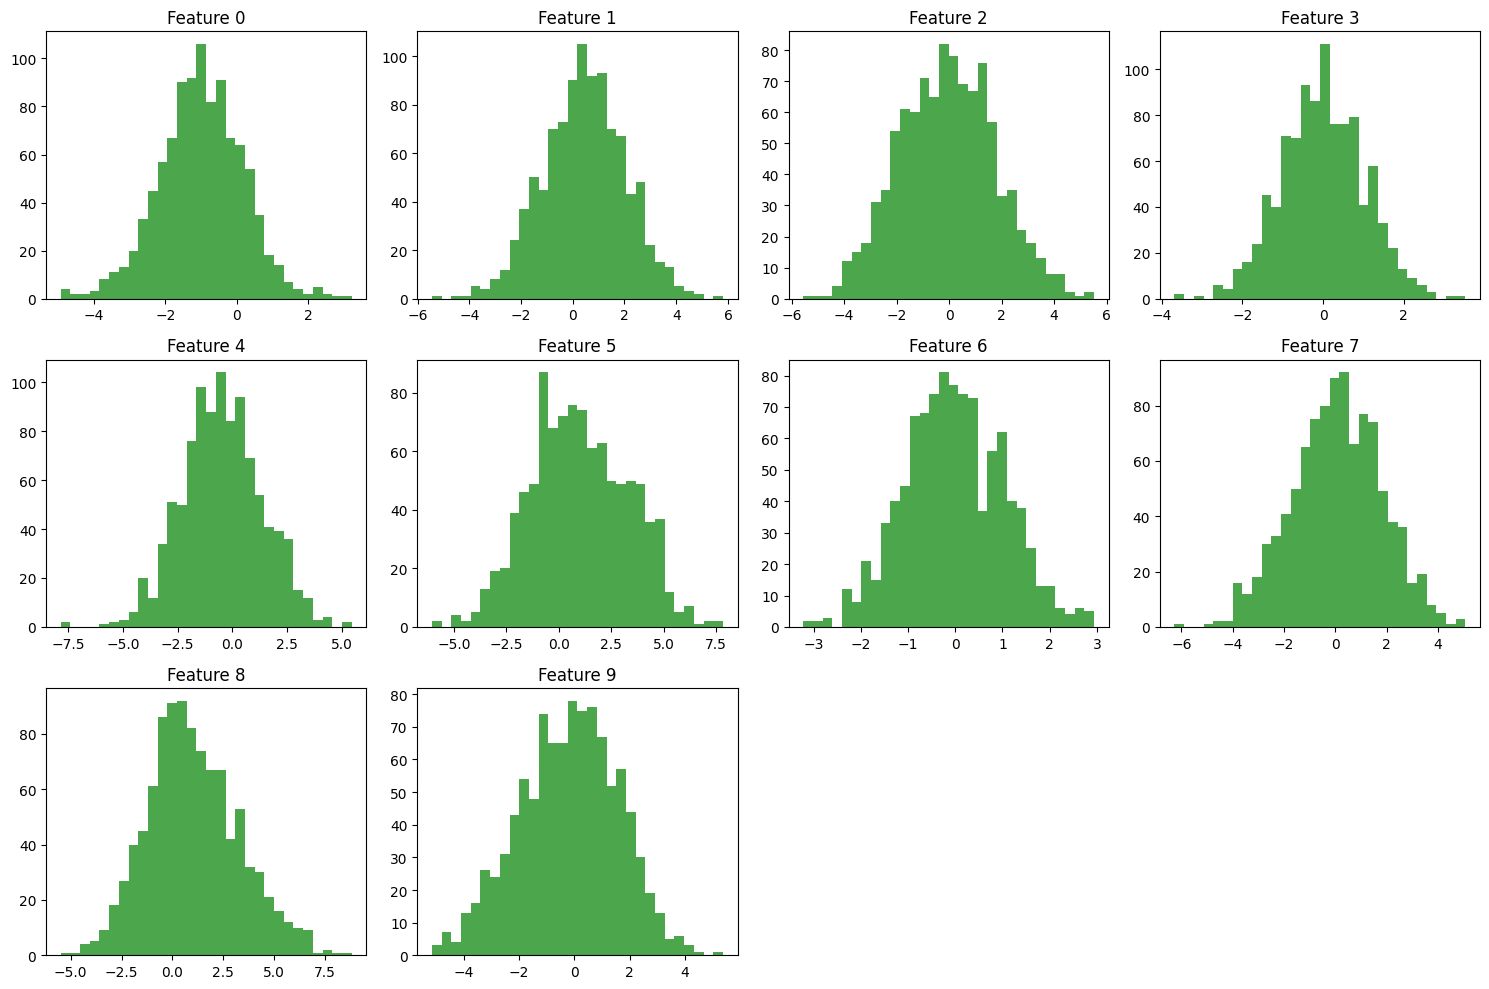

Duplicate rows: 0
Missing values per column:
 feature_0    0
feature_1    0
feature_2    0
feature_3    0
feature_4    0
feature_5    0
feature_6    0
feature_7    0
feature_8    0
feature_9    0
target       0
dtype: int64
Dataset shape: (1000, 11)


In [3]:
# EDA: distribuzione target, duplicati, missing values

plt.figure(figsize=(6, 4))
plt.hist(df["target"], bins=2, alpha=0.7, color="blue", edgecolor="black")
plt.xticks([0, 1])
plt.title("Distribution of Classes")
plt.show()

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    if i < 10:
        ax.hist(df[f"feature_{i}"], bins=30, alpha=0.7, color="green")
        ax.set_title(f"Feature {i}")
    else:
        ax.axis("off")
plt.tight_layout()
plt.show()

print("Duplicate rows:", df.duplicated().sum())
print("Missing values per column:\n", df.isnull().sum())
print("Dataset shape:", df.shape)

In [4]:
# Suddivisione train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (800, 10), Test: (200, 10)


In [5]:
# Standardizzazione
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Addestramento modello
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
print("Num. coefficienti:", log_reg.coef_.shape[1])

Num. coefficienti: 10


Calcola accuracy, precision e recall sul test set e interpreta: precision misura quanto sono "pulite" le previsioni positive, recall quanto recuperiamo della classe positiva. Confrontale per capire se serve riequilibrare la soglia o i pesi di classe.


In [7]:
y_pred = log_reg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

Accuracy: 0.80, Precision: 0.76, Recall: 0.74


# SECTION 4 — Esercizio 2: Interpretazione dei Coefficienti

I coefficienti della Logistic Regression indicano come varia il log-odds:

$$\log \frac{P(y=1)}{P(y=0)} = \mathbf{w}^T\mathbf{x} + b$$

Un peso **positivo** aumenta la probabilità di classe 1, uno **negativo** la diminuisce. L’**odds ratio** è $e^{w_i}$: quanto crescono gli odds quando la feature $i$ aumenta di 1 unità (dopo standardizzazione).

## Esempi applicati

- **Rischio credito**: un coefficiente positivo su "debito/ reddito" aumenta il logit di default; uno negativo su "anzianità lavorativa" lo riduce.
- **Marketing**: tempo speso sull’app e numero di sessioni possono spingere verso il click (classe 1), mentre un alto numero di ticket aperti può ridurlo.
- **Clinico**: una pressione sistolica elevata può incrementare il logit di un evento avverso, mentre una saturazione normale lo abbassa.

## Metodo di pensiero

Ordina i coefficienti, guarda il segno e la magnitudine: chiediti se ogni effetto ha senso causale o correlativo. Se vedi valori molto grandi su feature collineari, considera regolarizzazione o riduzione di dimensionalità.


In [8]:
coefficients = log_reg.coef_[0]
coef_df = pd.DataFrame(
    {
        "feature": [f"feature_{i}" for i in range(X.shape[1])],
        "coefficient": coefficients,
    }
).sort_values("coefficient", ascending=False)
coef_df

,feature,coefficient
9,feature_9,1.053712
4,feature_4,0.459241
1,feature_1,0.434214
8,feature_8,0.139125
6,feature_6,0.128376
0,feature_0,0.078696
7,feature_7,0.014746
3,feature_3,-0.009750
2,feature_2,-0.050386
5,feature_5,-1.161549


# SECTION 5 — Esercizio 3: Regressione Lineare

La regressione lineare cerca di minimizzare:

$$\text{MSE} = \frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2$$

Metriche chiave:

- **RMSE**:
  $$\text{RMSE} = \sqrt{\frac{1}{n}\sum (y_i - \hat{y}_i)^2}$$

- **R²**:
  $$R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}$$

Obiettivo: addestrare `LinearRegression` e valutare RMSE e $R^2$.

## Esempi applicati

- **Prezzi immobiliari**: stimare il prezzo da metri quadri, quartiere, anno di costruzione.
- **Domanda energetica**: prevedere il consumo orario da temperatura esterna, umidità, orario del giorno.
- **Logistica**: stimare il tempo di consegna da distanza, traffico medio, peso del pacco.

## Metodo di pensiero

Osserva i residui: devono essere piccoli e senza struttura sistematica. Se noti pattern curvilinei o varianza crescente, la relazione potrebbe non essere lineare e servono trasformazioni o modelli più flessibili.


In [9]:
X_reg, y_reg = make_regression(
    n_samples=800, n_features=8, n_informative=6, noise=10.0, bias=50.0, random_state=42
)
print("Shape:", X_reg.shape)

df_reg = pd.DataFrame(X_reg, columns=[f"feature_{i}" for i in range(8)])
df_reg["target"] = y_reg
df_reg

Shape: (800, 8)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,target
0,-0.547996,-0.214150,-0.321159,-1.114081,-0.942060,0.837154,-1.585626,-0.630931,35.509587
1,0.340051,0.570613,-0.331308,-0.278963,0.790372,0.968185,-0.612237,-0.279760,128.787981
2,-1.382800,0.926178,-1.398568,-1.037246,-0.875618,1.909417,0.562969,-0.190339,178.406252
3,-1.962626,0.349650,0.095344,0.260442,-1.008555,-1.564803,-0.263448,-0.538842,-144.376047
4,-0.164242,0.697587,0.308010,0.205075,1.888437,-0.836092,-1.302845,-1.623383,-70.058566
...,...,...,...,...,...,...,...,...,...
795,0.889037,0.573744,-1.288308,0.522251,2.272435,-1.276304,0.292715,-0.097915,-5.236786
796,-1.742772,0.409439,0.113394,-0.753862,1.124933,-0.276672,0.458994,0.382654,76.089895
797,-0.370614,0.771699,1.148766,-0.025554,0.543600,-2.848543,-1.739714,1.172729,-121.108967
798,-0.576892,0.835692,0.529804,-0.860413,1.006293,-1.129707,1.441569,-0.384556,-58.337398


In [10]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)
print(f"Train: {X_train_reg.shape}, Test: {X_test_reg.shape}")

Train: (640, 8), Test: (160, 8)


In [11]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)
print("Bias stimato:", lin_reg.intercept_)

Bias stimato: 49.30166856645045


In [12]:
y_pred_reg = lin_reg.predict(X_test_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)
print(f"RMSE: {rmse:.2f}, R^2: {r2:.2f}")

RMSE: 11.03, R^2: 0.99


# SECTION 6 — Conclusioni

- I modelli lineari sono interpretabili e costituiscono baseline robuste: perfetti per partire in contesti di credito, marketing e manutenzione predittiva dove servono spiegazioni rapide.
- Logistic Regression modella il log-odds tramite un iperpiano decisionale:
  $$\mathbf{w}^T \mathbf{x} + b = 0$$
- Linear Regression restituisce una stima continua tramite combinazione lineare.
- Quando i pattern non sono lineari (es. interazioni complesse tra sensori industriali o testi), occorre introdurre feature non lineari o modelli più espressivi (tree-based, kernel, boosting).

## Metodo di pensiero finale

Chiediti se la semplicità del modello è sufficiente per l’uso reale: se i residui sono piccoli e l’interpretabilità è un requisito, il modello lineare è spesso la scelta migliore. Altrimenti, usa questa baseline come riferimento per valutare miglioramenti di modelli più complessi.
